In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
sns.set_context("talk")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))

from ese.analysis.analyze_inf import load_cal_inference_stats
# Results loader object does everything
from ionpy.analysis import ResultsLoader
from pathlib import Path
root = Path("/storage/vbutoi/scratch/ESE")
rs = ResultsLoader()

# For using code without restarting.
%load_ext autoreload
%autoreload 2
# For using yaml configs.
%load_ext yamlmagic

/local/vbutoi/envs/UniverSegTF/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/mnt/hdd/home/vbutoi/envs/UniverSegTF/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/local/vbutoi/envs/UniverSegTF/lib/python3.9/site-packages/pydantic/_internal/_fields.py:149: UserWarning: Field "model_outputs" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/local/vbutoi/envs/UniverSegTF/lib/python3.9/site-packages/pydantic/_internal/_fields.py:149: UserWarning: Field "model_dir" has conflict with protected namespace "model_".

In [2]:
%%yaml results_cfg 

log:
    root: '/storage/vbutoi/scratch/ESE/inference'
    inference_groups: 
        # - '10_07_24_ISLES_3D_TempSweep_wAugExamples'
        - '10_08_24_OCTA_TempSweep'

options:
    verify_graceful_exit: True
    equal_rows_per_cfg_assert: False 

<IPython.core.display.Javascript object>

In [3]:
inference_df = load_cal_inference_stats(
    results_cfg=results_cfg,
    load_cached=True
)

Finished loading inference stats.
Log amounts: log_root                                                       log_set                                              
/storage/vbutoi/scratch/ESE/inference/10_08_24_OCTA_TempSweep  20241008_004727-PPPV-5af7e49c3942a12a4fa4be74a79c711d    7280
                                                               20241008_004732-HY13-7c1d677a9693e349472b52972ddc3085    7280
                                                               20241008_004736-42BS-a8062bc2694f68641a3ec64b60a6dfe0    3640
                                                               20241008_004740-XKYA-e55f891affac5be74093ef6e12f6ac0e    3640
                                                               20241008_004856-F51U-9471aab9d01c269cf1773ca9a2dd8ddc    7280
                                                               20241008_004901-101Z-9ef0fa95ec63ffce4cb4b8b78a2701d6    7280
                                                               20241008_004905-LOO7-15

In [4]:
# for ikey in inference_df.keys():
#     print(ikey)

In [5]:
def abs_vol_estimation_error(soft_volume, gt_volume):
    return np.abs(soft_volume - gt_volume)

def log_area_error(abs_vol_estimation_error):
    return np.log(abs_vol_estimation_error)

def relative_ave_error(abs_vol_estimation_error, gt_volume):
    return abs_vol_estimation_error / gt_volume

inference_df.augment(abs_vol_estimation_error)
inference_df.augment(relative_ave_error)
inference_df.augment(log_area_error)

# Goal 1: Find the Optimal Temperature for ALL Subjects.

In [6]:
cols_to_keep = [
    'abs_vol_estimation_error',
    'relative_ave_error',
    'temperature',
    'data_id',
    'split'
]
# Filter out the columns we want to keep
global_temp_df = inference_df[cols_to_keep]
# Drop the duplicates to keep only the first one
global_temp_df = global_temp_df.drop_duplicates()
# Zoom in on the temperature range [0.01 to 1.5]
sub_temp_df = global_temp_df[global_temp_df['temperature'] < 1.5]

<Figure size 2160x1440 with 0 Axes>

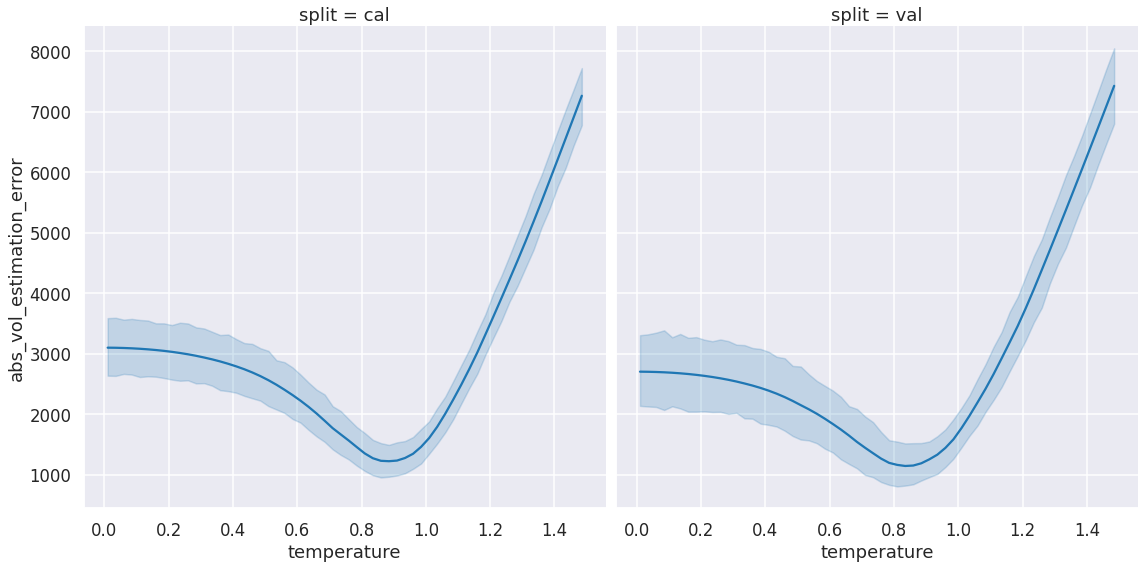

In [7]:
plt.figure(figsize=(30, 20))
# We want to plot the mean error vs temperature
sns.relplot(
    x='temperature',
    y='abs_vol_estimation_error',
    data=sub_temp_df,
    col='split',
    kind='line',
    height=8
)

In [8]:
# Groupy by temperature and split and average the error
mean_temp_df = sub_temp_df.groupby(['temperature', 'split']).mean()
# We want to get the temperature and abs_vol_estimation_error for the minimum error for each split
min_temp_df = mean_temp_df.groupby('split').idxmin()

<ipython-input-8-ecbb923f5eed>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_temp_df = sub_temp_df.groupby(['temperature', 'split']).mean()


In [9]:
mean_temp_df.loc[min_temp_df['abs_vol_estimation_error'].values]

,,abs_vol_estimation_error,relative_ave_error
temperature,split,,
0.885,cal,1222.109684,0.081826
0.835,val,1143.294512,0.077431


# The next question is what happens if we had a *per-image* temperature.

In [10]:
sub_cols_to_keep = [
    'log_area_error',
    'gt_volume',
    'temperature',
    'data_id',
    'split'
]
# Filter out the columns we want to keep
individual_temp_df = inference_df[sub_cols_to_keep]
# Drop the duplicates to keep only the first one
individual_temp_df = individual_temp_df.drop_duplicates().reset_index(drop=True)

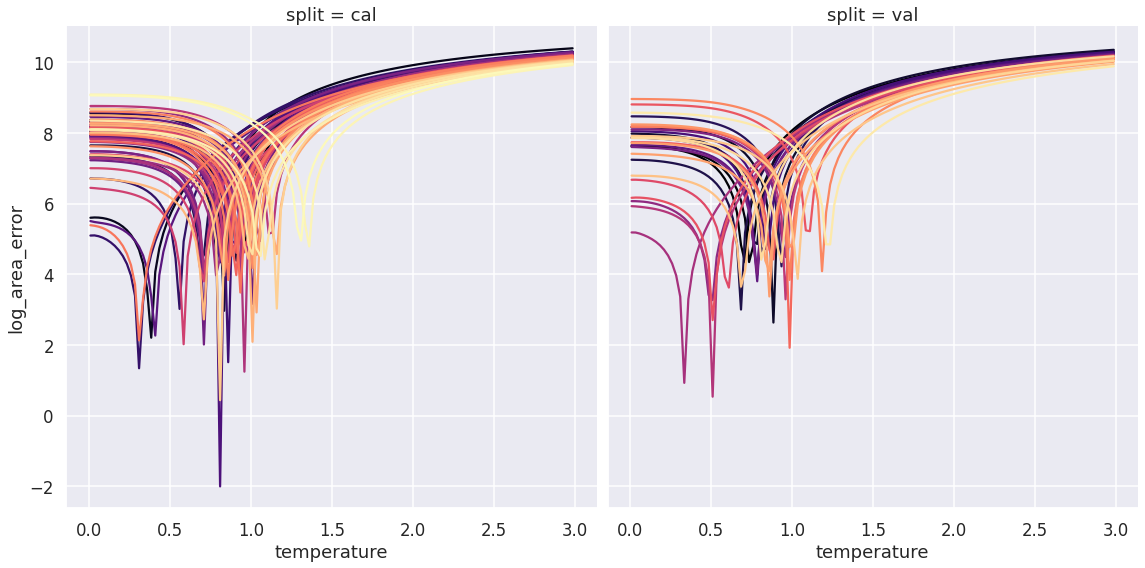

In [11]:
# We want to plot the mean error vs temperature
g = sns.relplot(
    data=individual_temp_df,
    x='temperature',
    y='log_area_error',
    hue='gt_volume',
    col='split',
    kind='line',
    height=8,
    legend=False,
    palette=sns.color_palette("magma", len(individual_temp_df['gt_volume'].unique()))
)